# Replication of results from Anderson et al. 2016

In [1]:
import numpy as np
import scipy.io
import xarray as xr
import pyhsmm_mvpa as hsmm
import itertools
import multiprocessing 
import matplotlib.pyplot as plt


cpus = multiprocessing.cpu_count()

%load_ext autoreload
%autoreload 2


# Initial fit

Reading the data

In [2]:
mat = scipy.io.loadmat('matlab/newbumps/starter.mat')

data = np.array(mat['normedscore10'])
starts = np.array(mat['x'][:,0]) -1#correcting to be 0 indexed
ends = np.array(mat['y'][:,0])-1#correcting to be 0 indexed
subjects = np.array(mat['subjects'])-1 #correcting to be 0 indexed

Initializing the hsmm object with data, starts, sampling frequency... all things shared across the different following fit

In [3]:
init = hsmm.hsmm(data, starts, ends, sf=100, bump_width=50)

Estimating the model with the maximum number of bumps possible

In [4]:
max_estimates = init.fit_single(init.max_bumps())

Estimating parameters for 8 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:203: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:209: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Parameters estimated for 8 bumps model


Example output:

## Iterative estimation of bumps from 1 to max_bumps

In [5]:
with multiprocessing.Pool(processes=cpus) as pool:
    iterative_results = pool.map(init.fit_single, np.arange(1,init.max_bumps()+1))
iterative_results = xr.concat(iterative_results, dim="n_bumps")
#For the single CPU automated version : init.fit_iterative(init.max_bumps())

Estimating parameters for 1 bumps model
Estimating parameters for 2 bumps model
Estimating parameters for 3 bumps model
Estimating parameters for 4 bumps model
Estimating parameters for 5 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 8 bumps model
Parameters estimated for 1 bumps model
Parameters estimated for 3 bumps model
Parameters estimated for 2 bumps model
Parameters estimated for 4 bumps model
Parameters estimated for 6 bumps model
Parameters estimated for 5 bumps model
Parameters estimated for 8 bumps model
Parameters estimated for 7 bumps model


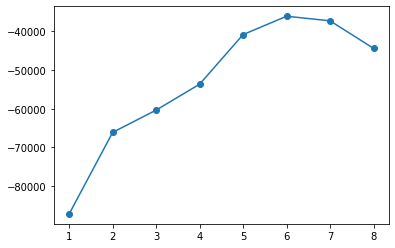

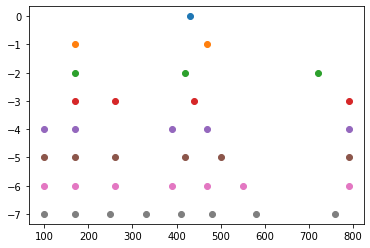

In [6]:
plt.plot(np.arange(init.max_bumps())+1, iterative_results.likelihoods,'o-')
plt.show()
for nbump in np.arange(init.max_bumps()):
    times = init.mean_bump_times(iterative_results.sel(n_bumps=nbump))
    plt.plot(times, -np.repeat(nbump, len(times)),'o')


## Roll-back estimation of bumps from max_bumps to 1 bumps

Getting the max n_bumps estimate first

In [7]:
#max_estimates = iterative_results.sel(n_bumps = init.max_bumps()-1)

In [8]:
bump_loo_results = [max_estimates]

i = 1
for n_bumps in np.arange(init.max_bumps()-1,0,-1):
    temp_best = bump_loo_results[-i]
    n_bumps_list = np.arange(n_bumps+1)
    possible_bumps = list(itertools.combinations(n_bumps_list, n_bumps))
    possible_flats = list(itertools.combinations(n_bumps_list+1, n_bumps))
    possible_flats = [np.insert(x,0,0) for x in possible_flats]
    with multiprocessing.Pool(processes=cpus) as pool:
        bump_loo_likelihood_temp = pool.starmap(init.fit_single, 
            zip(itertools.repeat(n_bumps),temp_best.magnitudes.values.T[possible_bumps,:],
                temp_best.parameters.values[possible_flats,:],
                itertools.repeat(1),itertools.repeat(True)))
                #repeat(np.tile([1,50], (n_bumps,1))),
                #repeat(np.tile([2,12], (n_bumps,1)))))
    models = xr.concat(bump_loo_likelihood_temp, dim="iteration")
    bump_loo_results.append(models.sel(iteration=[np.where(models.likelihoods ==models.likelihoods.max())[0][0]]))
    i+=1
bests = xr.concat(bump_loo_results, dim="n_bumps")
bests = bests.assign_coords({"n_bumps": np.arange(init.max_bumps(),0,-1)})
bests = bests.squeeze('iteration')
bests.to_netcdf('bests.nc')
bests

Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 7 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 6 bumps model
Parameters estimated for 6 bumps model
Parameters estimated for 6 bumps model
Parameters

<xarray.Dataset>
Dimensions:      (n_bumps: 8, stage: 9, params: 2, component: 10, bump: 8,
                  samples: 300, trial: 18271)
Coordinates:
  * n_bumps      (n_bumps) int64 8 7 6 5 4 3 2 1
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  (n_bumps) float64 -4.438e+04 -3.728e+04 ... -7.552e+04
    parameters   (n_bumps, stage, params) float64 2.0 3.757 2.0 ... nan nan nan
    magnitudes   (n_bumps, component, bump) float64 -0.2875 0.8038 ... nan nan
    eventprobs   (n_bumps, samples, trial, bump) float64 0.0 0.0 0.0 ... nan nan

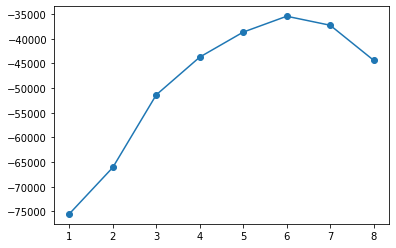

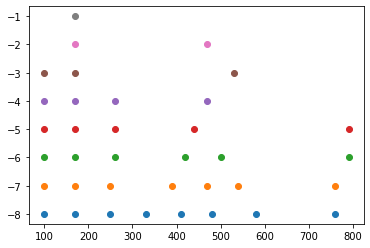

In [9]:
plt.plot(np.arange(init.max_bumps())+1, bests.likelihoods[::-1],'o-')
plt.show()
for nbump in np.arange(init.max_bumps(),0,-1):
    times = init.mean_bump_times(bests.sel(n_bumps=nbump))
    plt.plot(times, -np.repeat(nbump, len(times)),'o')


In [10]:

#Looping over possible number of bumps
subjects_idx = np.unique(subjects)
likelihoods_loo = []

for subject in subjects_idx:
    print(f'Subject {subject}')
    #Extracting data from left out subject
    subjects_idx_loo = subjects_idx[subjects_idx != subject]

    starts_left_out_idx = np.array([starts[idx] for idx, s in enumerate(subjects) if s not in subjects_idx_loo])
    ends_left_out_idx = np.array([ends[idx] for idx, s in enumerate(subjects) if s not in subjects_idx_loo])

    #Correct starts indexes to account for reoved subject, whole indexing needs improvement
    starts_loo = np.concatenate([starts[starts < starts_left_out_idx[0]], starts[starts > ends_left_out_idx[-1]]-ends_left_out_idx[-1]+1])
    ends_loo = np.concatenate([ends[ends < starts_left_out_idx[0]], ends[ends > ends_left_out_idx[-1]]-ends_left_out_idx[-1]])
    ends_loo[-1] = ends_loo[-1]-1
    starts_left_out = np.array([start - starts_left_out_idx[0]  for start in starts if start >= starts_left_out_idx[0] and start <= ends_left_out_idx[-1]])
    ends_left_out = np.array([end - starts_left_out_idx[0]  for end in ends if end >= starts_left_out_idx[0] and end <= ends_left_out_idx[-1]])


    samples_loo = np.array([sample for idx,sample in enumerate(data) if idx < starts_left_out_idx[0] or idx > ends_left_out_idx[-1]])
    samples_left_out = np.array([sample for idx,sample in enumerate(data) if idx >= starts_left_out_idx[0] and idx <= ends_left_out_idx[-1]])
    #Fitting the HsMM using previous estimated parameters as initial parameters
    model_loo = hsmm.hsmm(samples_loo, starts_loo, ends_loo, sf=100)
    with multiprocessing.Pool(processes=cpus) as pool:
        iterative_results_loo = pool.starmap(model_loo.fit_single, 
            zip(np.arange(init.max_bumps(),0,-1),#init.max_bumps to ensure that same number of maxbumps
                bests.magnitudes, bests.parameters, itertools.repeat(1), itertools.repeat(False), itertools.repeat(True)))
    iterative_results_loo = xr.concat(iterative_results_loo, dim="n_bumps")
    
    model_left_out = hsmm.hsmm(samples_left_out, starts_left_out, ends_left_out, sf=100)
    with multiprocessing.Pool(processes=cpus) as pool:
        likelihoods = pool.starmap(model_left_out.calc_EEG_50h, 
            zip(iterative_results_loo.magnitudes,
                iterative_results_loo.parameters,
                np.arange(init.max_bumps(),0,-1),itertools.repeat(True),itertools.repeat(True)))
    likelihoods_loo.append(likelihoods)
    np.save('likelihoods_loo',likelihoods_loo)

Subject 0
Estimating parameters for 8 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 5 bumps model
Estimating parameters for 4 bumps model
Estimating parameters for 3 bumps model
Estimating parameters for 2 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Parameters estimated for 3 bumps model
Parameters estimated for 2 bumps model
Parameters estimated for 4 bumps model
Parameters estimated for 5 bumps model
Parameters estimated for 6 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 8 bumps model
Subject 1
Estimating parameters for 8 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 5 bumps model
Estimating parameters for 4 bumps model
Estimating parameters for 3 bumps model
Estimating parameters for 2 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 b

Process ForkPoolWorker-455:
Process ForkPoolWorker-456:
Process ForkPoolWorker-463:
Process ForkPoolWorker-461:


KeyboardInterrupt: 

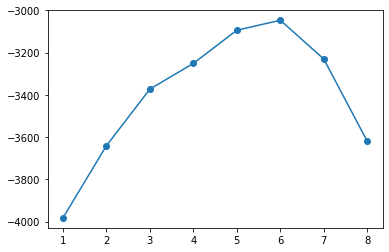

In [11]:
plt.plot(np.arange(8,0,-1),np.mean(np.array(likelihoods_loo),axis=0),'o-')

## Appendix

## Iterative estimation of bumps from 1 to max_bumps

Applying loocv on this method

In [ ]:
#Looping over possible number of bumps
subjects_idx = np.unique(subjects)
likelihoods_loo_classic = []

for subject in subjects_idx:
    print(f'Subject {subject}')
    #Extracting data from left out subject
    subjects_idx_loo = subjects_idx[subjects_idx != subject]

    starts_left_out_idx = np.array([starts[idx] for idx, s in enumerate(subjects) if s not in subjects_idx_loo])
    ends_left_out_idx = np.array([ends[idx] for idx, s in enumerate(subjects) if s not in subjects_idx_loo])

    #Correct starts indexes to account for reoved subject, whole indexing needs improvement
    starts_loo = np.concatenate([starts[starts < starts_left_out_idx[0]], starts[starts > ends_left_out_idx[-1]]-ends_left_out_idx[-1]+1])
    ends_loo = np.concatenate([ends[ends < starts_left_out_idx[0]], ends[ends > ends_left_out_idx[-1]]-ends_left_out_idx[-1]])
    ends_loo[-1] = ends_loo[-1]-1
    starts_left_out = np.array([start - starts_left_out_idx[0]  for start in starts if start >= starts_left_out_idx[0] and start <= ends_left_out_idx[-1]])
    ends_left_out = np.array([end - starts_left_out_idx[0]  for end in ends if end >= starts_left_out_idx[0] and end <= ends_left_out_idx[-1]])


    samples_loo = np.array([sample for idx,sample in enumerate(data) if idx < starts_left_out_idx[0] or idx > ends_left_out_idx[-1]])
    samples_left_out = np.array([sample for idx,sample in enumerate(data) if idx >= starts_left_out_idx[0] and idx <= ends_left_out_idx[-1]])
    #Fitting the HsMM using previous estimated parameters as initial parameters
    model_loo = hsmm.hsmm(samples_loo, starts_loo, ends_loo, sf=100)
    with multiprocessing.Pool(processes=cpus) as pool:
        iterative_results_loo = pool.starmap(model_loo.fit_single, 
            zip(np.arange(1,init.max_bumps()+1),#init.max_bumps to ensure that same number of maxbumps
                iterative_results.magnitudes, iterative_results.parameters, itertools.repeat(1), itertools.repeat(False), itertools.repeat(True)))
    iterative_results_loo = xr.concat(iterative_results_loo, dim="n_bumps")
    
    model_left_out = hsmm.hsmm(samples_left_out, starts_left_out, ends_left_out, sf=100)
    with multiprocessing.Pool(processes=cpus) as pool:
        likelihoods = pool.starmap(model_left_out.calc_EEG_50h, 
            zip(iterative_results_loo.magnitudes,
                iterative_results_loo.parameters,
                np.arange(1,init.max_bumps()+1),itertools.repeat(True),itertools.repeat(True)))
    likelihoods_loo_classic.append(likelihoods)
    np.save('likelihoods_loo_classic',likelihoods_loo_classic)